In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.set_default_dtype(torch.float64)
torch.autograd.set_detect_anomaly(True)

cuda


In [3]:
df=pd.read_csv('data/origindata.csv')

In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
df = df.sort_values(by=['location', 'date'])

In [6]:
# Drop columns with more than 70% missing values (arbitrary threshold, can be adjusted).
threshold = 0.70 * len(df)
df = df.dropna(thresh=threshold, axis=1)

# # Impute missing numerical values with the mean of the column.
# for col in df.select_dtypes(include=['float64', 'int64']).columns:
#     rolling_mean = df[col].fillna(0).rolling(window=3, min_periods=1).mean().shift(1)
#     df[col].fillna(rolling_mean, inplace=True)
for col in df.select_dtypes(include=['float64','int64']).columns:
    df[col].fillna(0, inplace=True)

# Impute missing categorical values with the mode of the column.
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(method='ffill', inplace=True)

In [7]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,population
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,...,54.42,18.6,2.58,1.34,1803.99,597.03,9.59,64.83,0.51,41128772
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,0.0,0.0,0.0,0.0,...,54.42,18.6,2.58,1.34,1803.99,597.03,9.59,64.83,0.51,41128772
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,0.0,0.0,0.0,0.0,...,54.42,18.6,2.58,1.34,1803.99,597.03,9.59,64.83,0.51,41128772
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,0.0,0.0,0.0,0.0,...,54.42,18.6,2.58,1.34,1803.99,597.03,9.59,64.83,0.51,41128772
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,0.0,0.0,0.0,0.0,...,54.42,18.6,2.58,1.34,1803.99,597.03,9.59,64.83,0.51,41128772


In [8]:
df['new_cases_next_day'] = df.groupby('location')['new_cases'].shift(-1)

In [9]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['new_cases_next_day', 'population']] # 'population' is a static value and not a daily feature

In [10]:
features_to_lag = [
    'new_cases_smoothed', 'total_deaths', 'new_deaths_smoothed','total_cases'
]

In [11]:
actual_features_to_lag = [col for col in features_to_lag if col in df.columns]

In [12]:
for col in actual_features_to_lag:
    if col in numerical_cols: # Ensure we are only lagging numerical columns that are still in df
        for i in range(1, 6):  # Lag for 1, 2, and 3 days
            df[f'{col}_lag_{i}'] = df.groupby('location')[col].shift(i)

In [13]:
# Drop any remaining rows with NaN values that might have been introduced by shifting (e.g., first few rows).
df.dropna(inplace=True)

# Remove the original columns listed in features_to_lag.
# Ensure to only drop columns that exist in the DataFrame.
columns_to_drop = [col for col in actual_features_to_lag if col in df.columns]
df = df.drop(columns=columns_to_drop)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 427910 entries, 5 to 429433
Data columns (total 43 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   iso_code                         427910 non-null  object        
 1   continent                        427910 non-null  object        
 2   location                         427910 non-null  object        
 3   date                             427910 non-null  datetime64[ns]
 4   new_cases                        427910 non-null  float64       
 5   new_deaths                       427910 non-null  float64       
 6   total_cases_per_million          427910 non-null  float64       
 7   new_cases_per_million            427910 non-null  float64       
 8   new_cases_smoothed_per_million   427910 non-null  float64       
 9   total_deaths_per_million         427910 non-null  float64       
 10  new_deaths_per_million           427910 non-null 

In [15]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

correlation_matrix = df[numerical_cols].corr()

correlations_with_target = correlation_matrix['new_cases_next_day'].sort_values(ascending=False)

print("--- Correlation matrix ---")
print(correlations_with_target)
print("\n" + "="*80 + "\n")


--- Correlation matrix ---
new_cases_next_day                 1.000000
new_cases_smoothed_lag_5           0.319286
new_cases_smoothed_lag_3           0.319286
new_cases_smoothed_lag_1           0.319286
new_cases_smoothed_lag_4           0.231175
new_cases_smoothed_lag_2           0.231175
new_deaths_smoothed_lag_5          0.181376
new_deaths_smoothed_lag_3          0.181376
new_deaths_smoothed_lag_1          0.181376
total_deaths_lag_5                 0.154191
total_deaths_lag_3                 0.154176
total_deaths_lag_1                 0.154162
population                         0.138200
new_deaths_smoothed_lag_4          0.137485
new_deaths_smoothed_lag_2          0.137485
total_cases_lag_5                  0.122145
total_cases_lag_3                  0.122136
total_cases_lag_1                  0.122127
total_deaths_lag_4                 0.114961
total_deaths_lag_2                 0.114949
total_cases_lag_4                  0.088689
total_cases_lag_2                  0.088681
new_c

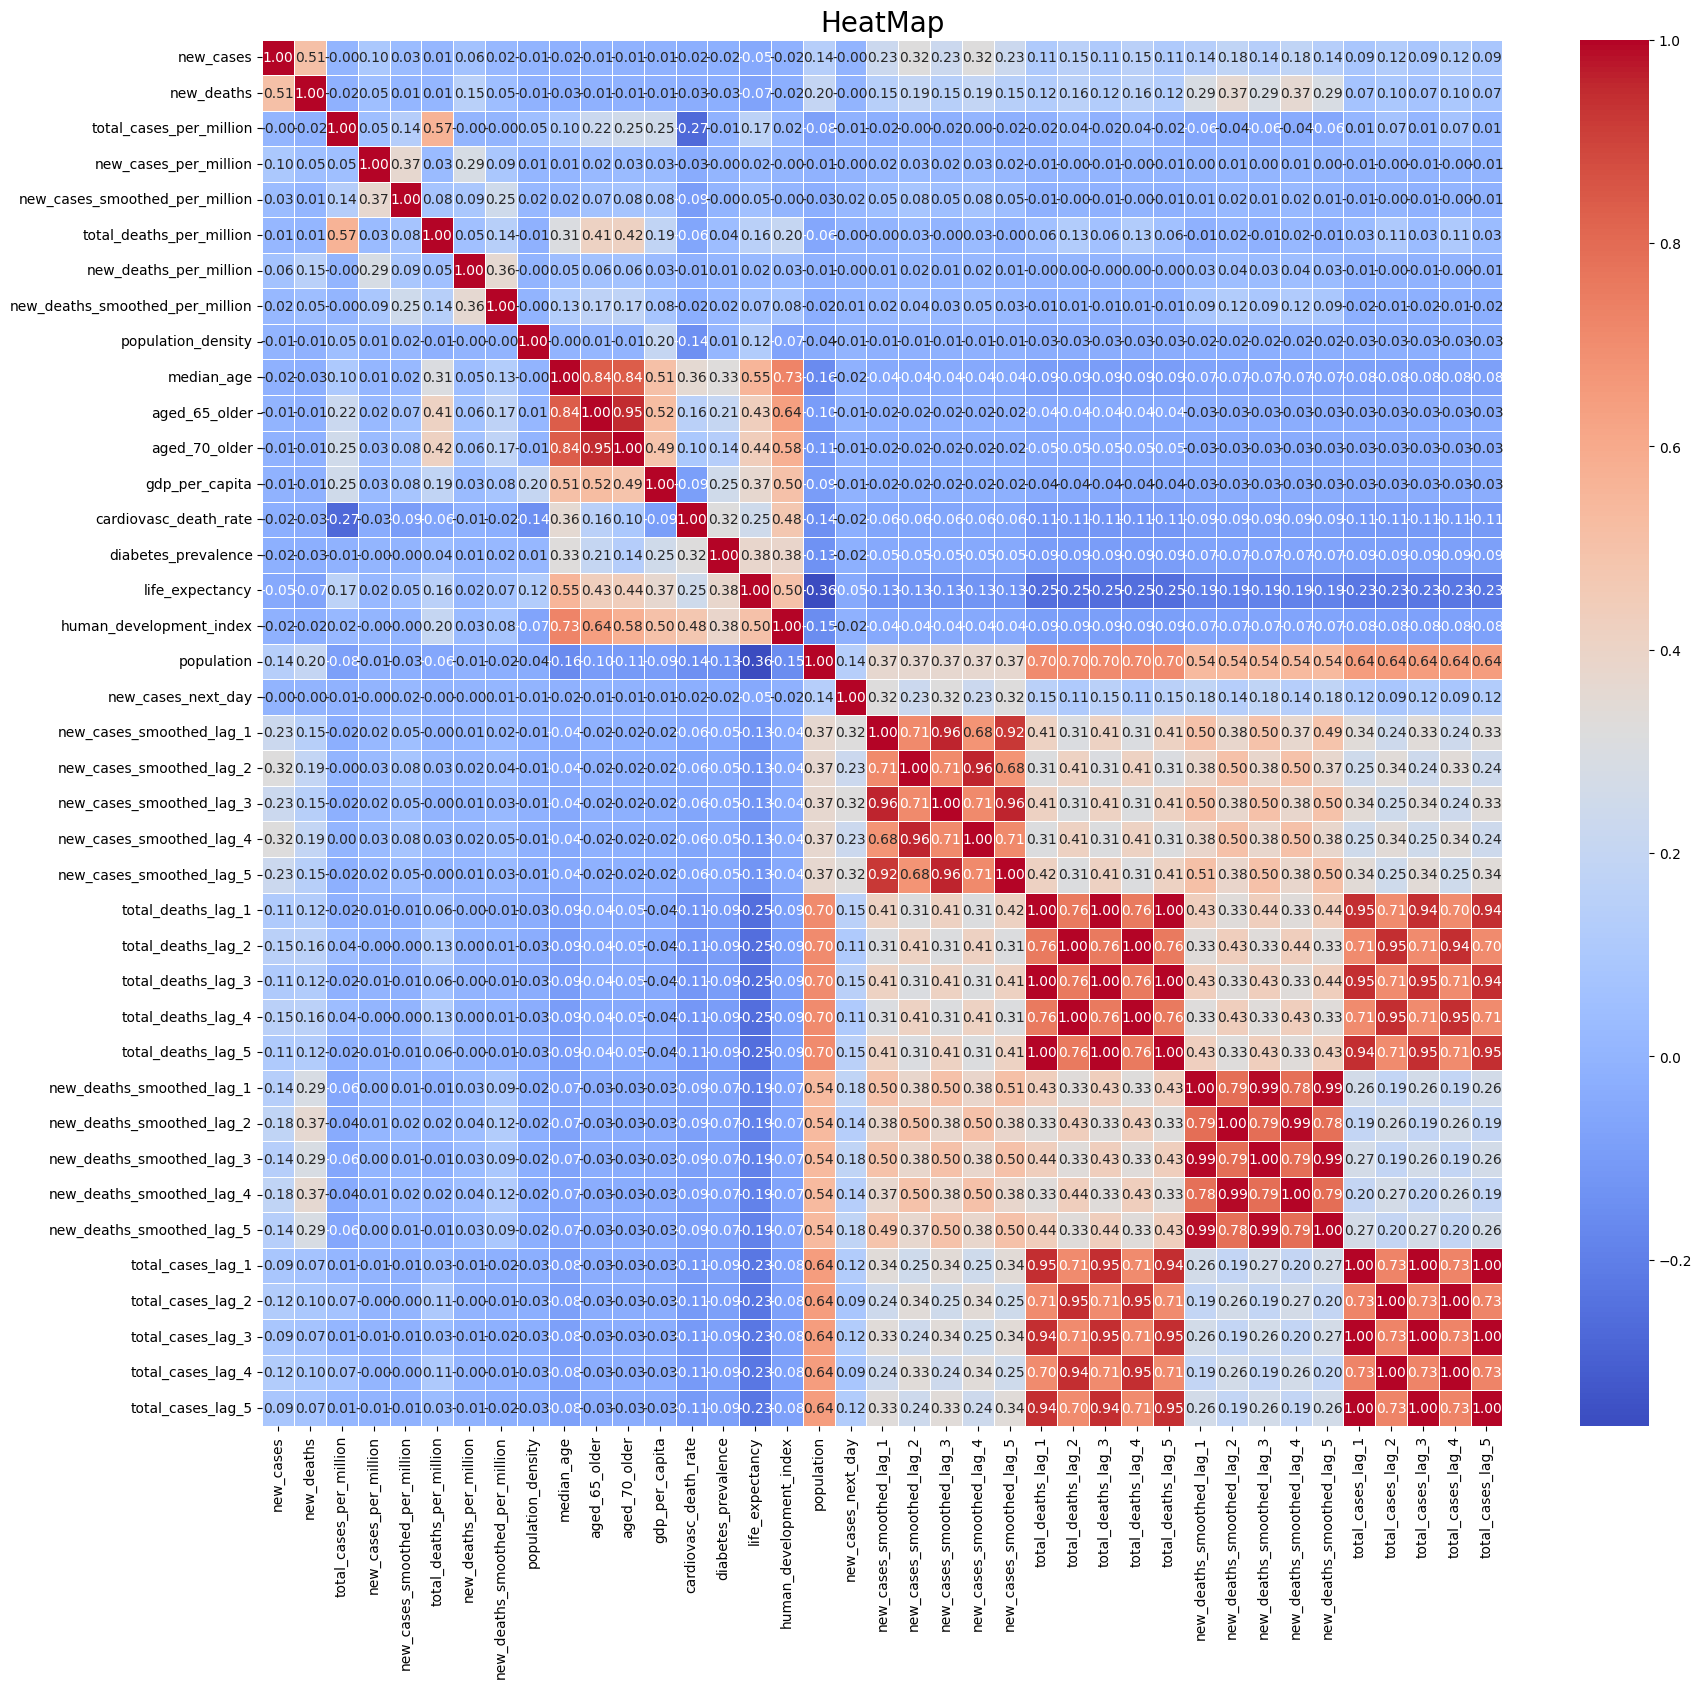

In [16]:
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('HeatMap', fontsize=20)
plt.show()

print("\n" + "="*80 + "\n")

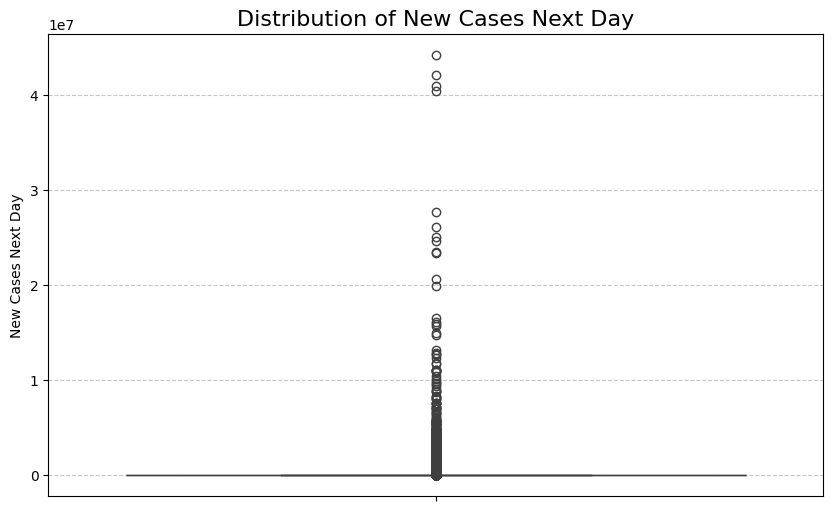

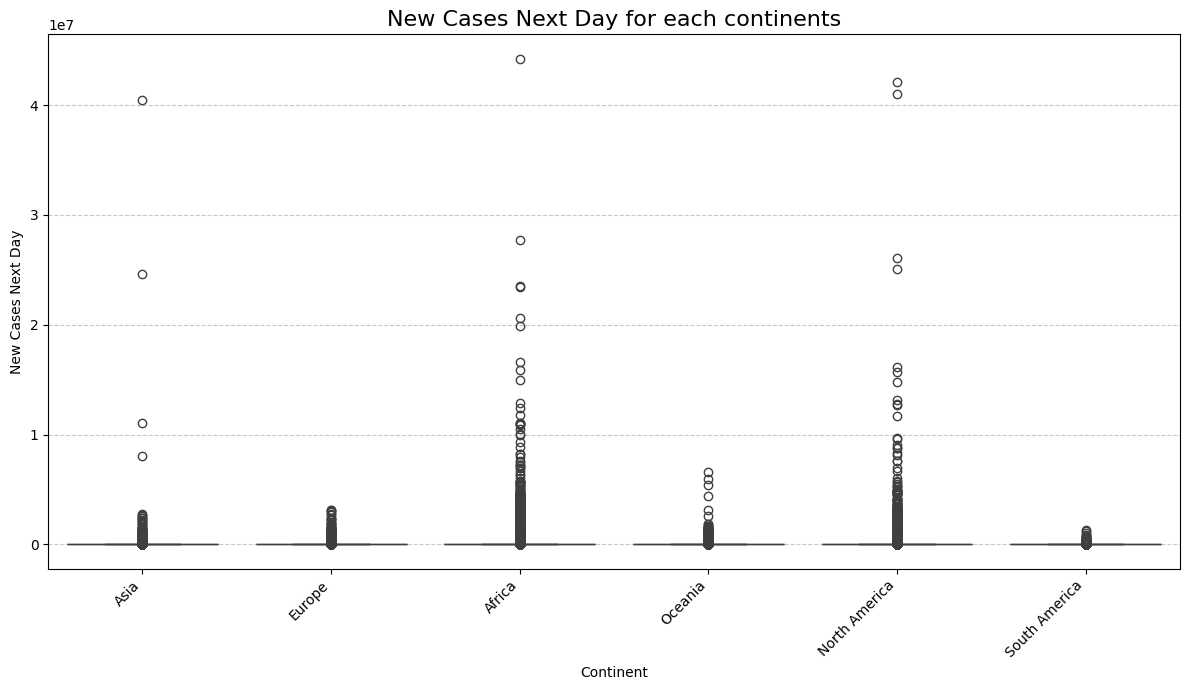

KeyError: 'new_cases_lag_1'

<Figure size 1000x600 with 0 Axes>

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['new_cases_next_day'])
plt.title('Distribution of New Cases Next Day', fontsize=16)
plt.ylabel('New Cases Next Day')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(12, 7))
sns.boxplot(x='continent', y='new_cases_next_day', data=df)
plt.title('New Cases Next Day for each continents', fontsize=16)
plt.xlabel('Continent')
plt.ylabel('New Cases Next Day')
plt.xticks(rotation=45, ha='right') # Xoay nhãn để dễ đọc
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(y=df['new_cases_lag_1'])
plt.title('Distribution of New Cases Lag 1', fontsize=16)
plt.ylabel('New Cases Lag 1')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n" + "="*80 + "\n")

In [18]:
output_csv_filename = 'data/processed_country_data.csv'
df.to_csv(output_csv_filename, index=False)